In [1]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import scipy as sp
import statsmodels.formula.api as sm
from sklearn.inspection import permutation_importance
from itertools import product

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#no dado original, havia uma coluna sem nome (com os indexes). seria difícil remover assim. Nomeei-a de "A", para priorizar 
#o index do pandas.

# Função para normalizar todas as colunas de um dataframe pelo método de valor mínimo 0 e máximo 1
def normalizar(df):
    resultado = df.copy()
    for coluna in df.columns:
        if df[coluna].max() == 0:
            continue
        else:
            valor_max = df[coluna].max()
            valor_min = df[coluna].min()
            resultado[coluna] = (df[coluna] - valor_min) / (valor_max - valor_min)
    return resultado


In [3]:
#criando o DataFrame "df_chem"
df = pd.read_csv("Minerals_Database3.csv")  # Importação do dataset para ser utilizado como dataframe
# Remoção de colunas não necessárias para o dataframe

df = df.drop(['A'], axis=1)
df = df.drop(['Name'], axis=1)

dados_cat = df.reindex(df.columns[[0,2,4]], axis = 1) # Remoção de dados categóricos
dados_categoricos = dados_cat.astype("category") # Tratamento de dados para o tipo categórico
newlist = [x for x in range(7,135)] # Range para pegarmos dados que estão em porcentagem
porcent_df = df.reindex(df.columns[newlist], axis = 1) # Coleta dos dados de elementos em porcentagem
df_chem = df.reindex(df.columns[[1,3,5,135,136,137]], axis=1) # Reindexação de um dataframe contendo apenas propriedades fisico-químicas
df_chem
df_chem, dados_categoricos

df_remove=df_chem.loc[(df_chem["Refractive Index"] == 0.000)] #remove as linhas (objetos), cujo valor do índice de refração é 0

df_chem = df_chem.drop(df_remove.index) #considera que o dataframe df_chem é o dataframe com as linhas removidas
print(df_chem)

     Mohs Hardness  Specific Gravity  Refractive Index  Molar Mass  \
0             4.50             3.240             1.580  817.339002   
1             2.75             3.446             1.592  435.069330   
2             2.00             4.420             2.085  921.092220   
4             5.50             1.050             1.634  861.185368   
5             3.50             3.295             1.457  225.618151   
..             ...               ...               ...         ...   
803           7.50             4.650             1.928  526.041800   
805           6.50             3.230             1.702  379.378178   
806           3.50             2.180             1.590  492.887716   
807           7.00             3.411             1.596  263.580584   
808           0.00             3.146             1.633  576.801907   

     Molar Volume  Calculated Density  
0        0.123390               5.498  
1        0.056083               6.439  
2        0.122631               6.234  

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

tamanho = 0.25 # Fração de dados escolhida para treino e teste
seed = 2000

i = df_chem.index
i_treino, i_teste = train_test_split(i, test_size=tamanho, random_state = seed)

df_treino = df_chem.loc[i_treino]
df_teste = df_chem.loc[i_teste]

#print(df_treino)
#print()
#print(df_teste)

In [5]:
#Definição dos parâmetros
tamanho_rf = 0.1
seed_rf = 1024
nome = 'df_chem'
atributos = ["Mohs Hardness","Specific Gravity", 'Molar Mass', 'Molar Volume', 'Calculated Density']
#atributos = ["Mohs Hardness", "Refractive Index", "Dispersion", 'Specific Gravity']
target = ["Refractive Index"]

i = df_chem.index
i_treino, i_teste = train_test_split(i, test_size=tamanho_rf, random_state = seed_rf)

df_treino = df_chem.loc[i_treino]
df_teste = df_chem.loc[i_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(atributos, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values
X_teste = df_teste.reindex(atributos, axis=1).values
y_teste = df_teste.reindex(target, axis=1).values

In [6]:
#Treinamento do modelo
from sklearn.ensemble import RandomForestRegressor

# alterando o formato do target
print(y_treino.shape, y_teste.shape)
y_treino = y_treino.ravel()
y_teste = y_teste.ravel()
print(y_treino.shape, y_teste.shape)

# cria o modelo
modelo_rf = RandomForestRegressor(random_state=seed_rf)

# treina o modelo
modelo_rf.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_rf.predict(X_teste)
print()
print(previsao)

(529, 1) (59, 1)
(529,) (59,)

[1.88681 1.80088 2.16682 1.54134 1.51015 1.71598 1.57594 1.68825 1.5587
 1.96628 1.95053 1.73915 1.69619 1.54109 1.63718 1.59065 1.53792 2.2613
 1.76548 1.6357  1.56768 1.66671 1.83057 1.58353 1.68878 1.72677 1.8073
 1.67926 1.64546 1.50017 1.47037 1.82262 1.56548 1.45511 1.53231 1.66102
 1.84982 1.58325 1.86202 1.64401 1.57959 1.50515 1.71774 1.45254 1.53235
 1.81882 1.87133 1.72664 1.76834 1.50138 1.57467 1.66349 1.76633 2.02493
 1.54335 1.70018 1.54526 1.57831 1.84034]


In [7]:
#Performance do modelo de floresta aleatória
from sklearn.metrics import mean_squared_error

y_verdadeiro = y_teste
y_previsao = modelo_rf.predict(X_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo de floresta aleatória foi de {RMSE}")

O RMSE do modelo de floresta aleatória foi de 0.10183925376189534


#### melhor que o de baseline, com RMSE de 0.2560

In [8]:
#CRITERIO = 'absolute_error'
N_ARVORES = 50
N_FOLHAS = 6
N_PROFUNDIDADE = 3
MIN_SPLIT = 2
MIN_FOLHAS = 1
MIN_PESO = 0.0
MAXIMO_FEATURES = 1.0
MAXIMO_FOLHA = None
MIN_IMPUREZA = 0.0
BOOTSTRAP = True
OOB_SCORE = False
JOBS = 4
VERBOSE = 0
START = False
ALPHA = 0.0
MAXIMO_SAMPLE = None

#or n_folhas, n_profundidade, n_arvores in product(
#   NUM_FOLHAS, NUM_PROFUNDIDADE, NUM_ARVORES
#):
modelo_rf = RandomForestRegressor(
        #criterion= CRITERIO,
        n_estimators=N_ARVORES,
        max_leaf_nodes=N_FOLHAS,
        max_depth=N_PROFUNDIDADE,
        random_state=seed_rf,
        min_samples_split=MIN_SPLIT,
        min_samples_leaf=MIN_FOLHAS,
        min_weight_fraction_leaf=MIN_PESO,
        max_features=MAXIMO_FEATURES,
        min_impurity_decrease=MIN_IMPUREZA,
        bootstrap=BOOTSTRAP,
        oob_score=OOB_SCORE,
        n_jobs=JOBS,
        verbose=VERBOSE,
        warm_start=START,
        ccp_alpha=ALPHA,
        max_samples=MAXIMO_SAMPLE,
    )

modelo_rf.fit(X_treino, y_treino)

y_verdadeiro = y_teste
y_previsao = modelo_rf.predict(X_teste)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(
        f"O RMSE do modelo RF usando "
        f"n_estimators={N_ARVORES} max_leaf_nodes={N_FOLHAS} "
        f"e max_depth={N_PROFUNDIDADE} foi de {RMSE:.4f}."
    )

O RMSE do modelo RF usando n_estimators=50 max_leaf_nodes=6 e max_depth=3 foi de 0.1155.


O RMSE do modelo acima foi de "0.1155", muito melhor que o baseline.
Isso se deve pois a RMSE do modelo de baseline foi de "0.2560".

In [9]:
#CRITERIO = 'absolute_error'
#N_ARVORES = [50, 100, 500, 1000]
N_ARVORES = [20, 40, 60, 80]
#N_FOLHAS = [None, 10, 20 ,30]
N_FOLHAS = [5, 10, 20, 30]
#N_PROFUNDIDADE = [None,3,6,9]
N_PROFUNDIDADE = [3,4,5,6]
MIN_SPLIT = [2,4,6,8]
MIN_FOLHAS = [1,2,4,6]
#MIN_PESO = 0.0
#MAXIMO_FEATURES = 1.0
#MAXIMO_FOLHA = None
#MIN_IMPUREZA = 0.0
#BOOTSTRAP = True
#OOB_SCORE = False
JOBS = [6,6,6,6]
#VERBOSE = 0
#START = False
#ALPHA = 0.0
#MAXIMO_SAMPLE = None

for n_folhas, n_profundidade, n_arvores,min_split,min_folhas,num_jobs in product(N_FOLHAS, N_PROFUNDIDADE,N_ARVORES,MIN_SPLIT,MIN_FOLHAS, JOBS):
    modelo_rf = RandomForestRegressor(
        #criterion= criterio,
        n_estimators=n_arvores,
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=seed_rf,
        min_samples_split=min_split,
        min_samples_leaf=min_folhas,
        #min_weight_fraction_leaf=min_peso,
        #max_features=maximo_features,
        #min_impurity_decrease=min_impureza,
        #bootstrap=bootstrap,
        #oob_score=oob_score,
        n_jobs=num_jobs,
        #verbose=verbose,
        #warm_start=start,
        #ccp_alpha=alpha,
        #max_samples=maximo_sample,
    )

    modelo_rf.fit(X_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_rf.predict(X_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
        f"O RMSE do modelo RF usando "
        f"n_estimators={n_arvores} max_leaf_nodes={n_folhas}"
        f", max_depth={n_profundidade}"
        f", max_leaf_nodes={n_folhas}"
        f", min_samples_split={min_split}"
        f", min_samples_leaf={min_folhas}"
        f", n_jobs={num_jobs}"
        f" foi de {RMSE:.4f}."
    )

O RMSE do modelo RF usando n_estimators=20 max_leaf_nodes=5, max_depth=3, max_leaf_nodes=5, min_samples_split=2, min_samples_leaf=1, n_jobs=6 foi de 0.1188.
O RMSE do modelo RF usando n_estimators=20 max_leaf_nodes=5, max_depth=3, max_leaf_nodes=5, min_samples_split=2, min_samples_leaf=1, n_jobs=6 foi de 0.1188.
O RMSE do modelo RF usando n_estimators=20 max_leaf_nodes=5, max_depth=3, max_leaf_nodes=5, min_samples_split=2, min_samples_leaf=1, n_jobs=6 foi de 0.1188.
O RMSE do modelo RF usando n_estimators=20 max_leaf_nodes=5, max_depth=3, max_leaf_nodes=5, min_samples_split=2, min_samples_leaf=1, n_jobs=6 foi de 0.1188.
O RMSE do modelo RF usando n_estimators=20 max_leaf_nodes=5, max_depth=3, max_leaf_nodes=5, min_samples_split=2, min_samples_leaf=2, n_jobs=6 foi de 0.1188.
O RMSE do modelo RF usando n_estimators=20 max_leaf_nodes=5, max_depth=3, max_leaf_nodes=5, min_samples_split=2, min_samples_leaf=2, n_jobs=6 foi de 0.1188.
O RMSE do modelo RF usando n_estimators=20 max_leaf_nodes=

Para o modelo acima, "0.0985" foi o menor RMSE. Ainda sim, é melhor que a baseline, que apresenta um RMSE de "0.2560"

In [10]:
# Plotagem do RMSE em função do Hiperparâmetro N° de árvores
lista_RMSE = []
arvores = range(20,80)
for i in arvores:
    modelo_dt = RandomForestRegressor(n_estimators=i)
    modelo_dt.fit(X_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(X_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE.append(RMSE_valores)
    print(lista_RMSE)

[0.10534855263539632]
[0.10534855263539632, 0.11369722746583527]
[0.10534855263539632, 0.11369722746583527, 0.11088310984810439]
[0.10534855263539632, 0.11369722746583527, 0.11088310984810439, 0.10610315860789762]
[0.10534855263539632, 0.11369722746583527, 0.11088310984810439, 0.10610315860789762, 0.10557981906248662]
[0.10534855263539632, 0.11369722746583527, 0.11088310984810439, 0.10610315860789762, 0.10557981906248662, 0.11433402720219034]
[0.10534855263539632, 0.11369722746583527, 0.11088310984810439, 0.10610315860789762, 0.10557981906248662, 0.11433402720219034, 0.1092478901138762]
[0.10534855263539632, 0.11369722746583527, 0.11088310984810439, 0.10610315860789762, 0.10557981906248662, 0.11433402720219034, 0.1092478901138762, 0.09837522925796428]
[0.10534855263539632, 0.11369722746583527, 0.11088310984810439, 0.10610315860789762, 0.10557981906248662, 0.11433402720219034, 0.1092478901138762, 0.09837522925796428, 0.115289122386924]
[0.10534855263539632, 0.11369722746583527, 0.110883

[Text(0.5, 0, 'N° de Árvores'), Text(0, 0.5, 'RMSE')]

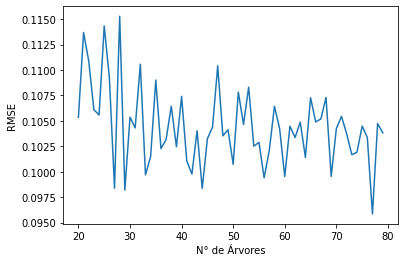

In [11]:
relacao_folha_RMSE = sns.lineplot(x = arvores, y = lista_RMSE)
relacao_folha_RMSE.set(xlabel = "N° de Árvores", ylabel = "RMSE")

In [12]:
# Plotagem do RMSe em função do hiperparâmetro número de folhas
lista_RMSE2 = []
num_folhas = range(5,30)
for i in num_folhas:
    modelo_dt = RandomForestRegressor(max_leaf_nodes=i)
    modelo_dt.fit(X_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(X_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE2.append(RMSE_valores)
    print(lista_RMSE2)

[0.11687200909350888]
[0.11687200909350888, 0.11385156666909964]
[0.11687200909350888, 0.11385156666909964, 0.10848319049582494]
[0.11687200909350888, 0.11385156666909964, 0.10848319049582494, 0.10647012867412098]
[0.11687200909350888, 0.11385156666909964, 0.10848319049582494, 0.10647012867412098, 0.10444190679409118]
[0.11687200909350888, 0.11385156666909964, 0.10848319049582494, 0.10647012867412098, 0.10444190679409118, 0.10434266648174848]
[0.11687200909350888, 0.11385156666909964, 0.10848319049582494, 0.10647012867412098, 0.10444190679409118, 0.10434266648174848, 0.10370500057769616]
[0.11687200909350888, 0.11385156666909964, 0.10848319049582494, 0.10647012867412098, 0.10444190679409118, 0.10434266648174848, 0.10370500057769616, 0.10453416796039611]
[0.11687200909350888, 0.11385156666909964, 0.10848319049582494, 0.10647012867412098, 0.10444190679409118, 0.10434266648174848, 0.10370500057769616, 0.10453416796039611, 0.1067701430169086]
[0.11687200909350888, 0.11385156666909964, 0.10

[Text(0.5, 0, 'N° de Folhas'), Text(0, 0.5, 'RMSE')]

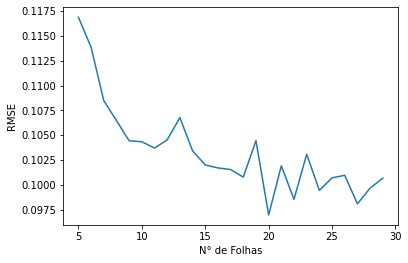

In [13]:
relacao_folha_RMSE = sns.lineplot(x = num_folhas, y = lista_RMSE2)
relacao_folha_RMSE.set(xlabel = "N° de Folhas", ylabel = "RMSE")

In [14]:
# Plotagem do RMSE em função do hiperparêmtro profundidade
lista_RMSE3 = []
profundidade = range(3,6)
for i in profundidade:
    modelo_dt = RandomForestRegressor(max_depth=i)
    modelo_dt.fit(X_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(X_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE3.append(RMSE_valores)
    print(lista_RMSE3)

[0.11270566872656294]
[0.11270566872656294, 0.10190838817188466]
[0.11270566872656294, 0.10190838817188466, 0.10008533212851009]


[Text(0.5, 0, 'Profundidade'), Text(0, 0.5, 'RMSE')]

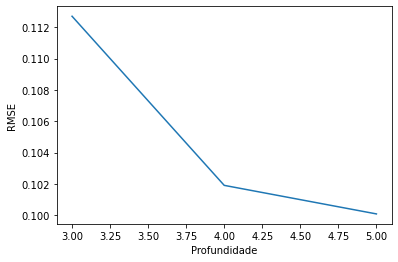

In [15]:
relacao_folha_RMSE = sns.lineplot(x = profundidade, y = lista_RMSE3)
relacao_folha_RMSE.set(xlabel = "Profundidade", ylabel = "RMSE")

In [16]:
# Plotagem do RMSE em função do hiperparêmtro de mínimo split
lista_RMSE4 = []
minimo_split = range(2,14)
for i in minimo_split:
    modelo_dt = RandomForestRegressor(min_samples_split=i)
    modelo_dt.fit(X_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(X_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE4.append(RMSE_valores)
    print(lista_RMSE4)

[0.09550670092739004]
[0.09550670092739004, 0.10440633636297258]
[0.09550670092739004, 0.10440633636297258, 0.10537986720230576]
[0.09550670092739004, 0.10440633636297258, 0.10537986720230576, 0.1082965482905465]
[0.09550670092739004, 0.10440633636297258, 0.10537986720230576, 0.1082965482905465, 0.10429698562372765]
[0.09550670092739004, 0.10440633636297258, 0.10537986720230576, 0.1082965482905465, 0.10429698562372765, 0.10321329676047608]
[0.09550670092739004, 0.10440633636297258, 0.10537986720230576, 0.1082965482905465, 0.10429698562372765, 0.10321329676047608, 0.10363659259774487]
[0.09550670092739004, 0.10440633636297258, 0.10537986720230576, 0.1082965482905465, 0.10429698562372765, 0.10321329676047608, 0.10363659259774487, 0.10540102062046465]
[0.09550670092739004, 0.10440633636297258, 0.10537986720230576, 0.1082965482905465, 0.10429698562372765, 0.10321329676047608, 0.10363659259774487, 0.10540102062046465, 0.10765541227080119]
[0.09550670092739004, 0.10440633636297258, 0.1053798

[Text(0.5, 0, 'Valor mínimo de split'), Text(0, 0.5, 'RMSE')]

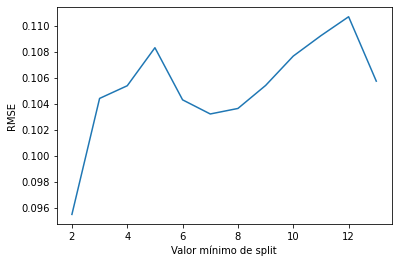

In [17]:
relacao_folha_RMSE = sns.lineplot(x = minimo_split, y = lista_RMSE4)
relacao_folha_RMSE.set(xlabel = "Valor mínimo de split", ylabel = "RMSE")

In [18]:
# Plotagem do RMSE em função do hiperparâmetro de quantidade de folhas mínimas
lista_RMSE5 = []
folhas_min = range(1,6)
for i in folhas_min:
    modelo_dt = RandomForestRegressor(min_samples_leaf=i)
    modelo_dt.fit(X_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(X_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE5.append(RMSE_valores)
    print(lista_RMSE5)

[0.10391975253914264]
[0.10391975253914264, 0.09887165024606419]
[0.10391975253914264, 0.09887165024606419, 0.10413519527778164]
[0.10391975253914264, 0.09887165024606419, 0.10413519527778164, 0.1043985998829832]
[0.10391975253914264, 0.09887165024606419, 0.10413519527778164, 0.1043985998829832, 0.11125725886074797]


[Text(0.5, 0, 'Val min folhas'), Text(0, 0.5, 'RMSE')]

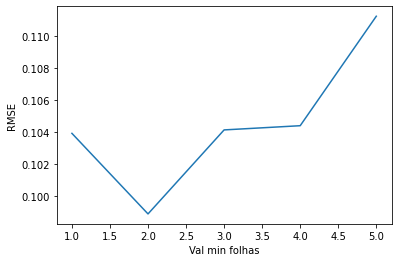

In [19]:
relacao_folha_RMSE = sns.lineplot(x = folhas_min, y = lista_RMSE5)
relacao_folha_RMSE.set(xlabel = "Val min folhas", ylabel = "RMSE")

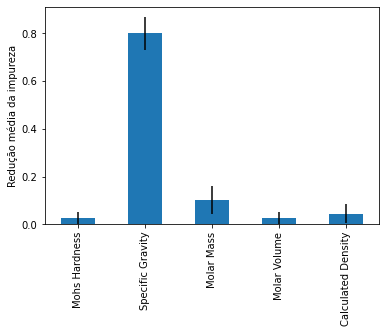

In [20]:
#Análise da importância e desvio padrão dos atributos
importancia = modelo_rf.feature_importances_
desvio_padrao = np.std(
    [arvore.feature_importances_ for arvore in modelo_rf.estimators_], axis=0
)

serie_importancia = pd.Series(importancia, index=atributos)

fig, axe = plt.subplots()
serie_importancia.plot.bar(yerr=desvio_padrao, ax=axe)
axe.set_ylabel("Redução média da impureza")
plt.show()

"Specific Gravity" tem maior importância

In [21]:
N_REPETICOES = 10


def R2_1param(modelo, x, y):
    """Computa o coef. de determinação quando hip. alt. não tem coef. linear."""
    y_pred = modelo.predict(x).ravel()
    y_true = (np.array(y)).ravel()
    return 1 - sum((y_true - y_pred) ** 2) / sum(y_true**2)


X_local = X_treino
y_local = y_treino

R2 = R2_1param(modelo_rf, X_local, y_local)
print(f"O R^2 da previsão é de {R2}")

# Aqui que calculamos a importância das features
r = permutation_importance(
    modelo_rf,
    X_local,
    y_local,
    n_repeats=N_REPETICOES,
    random_state=seed_rf,
    scoring=R2_1param,
)

print()

# Aqui nós exibimos os resultados obtidos
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{atributos[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

O R^2 da previsão é de 0.9933638380075986

Specific Gravity0.022 +/- 0.001
Molar Mass0.002 +/- 0.000
Calculated Density0.001 +/- 0.000
Mohs Hardness0.000 +/- 0.000
Molar Volume0.000 +/- 0.000


In [22]:
X_local = X_teste
y_local = y_teste

R2 = R2_1param(modelo_rf, X_local, y_local)
print(f"O R^2 da previsão é de {R2}")

# Aqui que calculamos a importância das features
r = permutation_importance(
    modelo_rf,
    X_local,
    y_local,
    n_repeats=N_REPETICOES,
    random_state=seed_rf,
    scoring=R2_1param,
)

print()

# Aqui nós exibimos os resultados obtidos
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{atributos[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

O R^2 da previsão é de 0.995167007865204

Specific Gravity0.013 +/- 0.002
Mohs Hardness0.000 +/- 0.000


In [23]:
#CRITERIO = 'absolute_error'
#N_ARVORES = [50, 100, 500, 1000]
N_ARVORES = [100, 150, 200, 250]
N_FOLHAS = [None, 10, 20 ,30]
N_PROFUNDIDADE = [None,3,6,9]
#MIN_SPLIT = [2,4,6,8]
#MIN_FOLHAS = [1,2,4,6]
#MIN_PESO = 0.0
#MAXIMO_FEATURES = 1.0
#MAXIMO_FOLHA = None
#MIN_IMPUREZA = 0.0
#BOOTSTRAP = True
#OOB_SCORE = False
JOBS = [4,4,4,4]
#VERBOSE = 0
#START = False
#ALPHA = 0.0
#MAXIMO_SAMPLE = None

for n_folhas, n_profundidade, n_arvores,num_jobs in product(N_FOLHAS, N_PROFUNDIDADE,N_ARVORES, JOBS):
    modelo_rf = RandomForestRegressor(
        #criterion= criterio,
        n_estimators=n_arvores,
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=seed_rf,
        #min_samples_split=min_split,
        #min_samples_leaf=min_folhas,
        #min_weight_fraction_leaf=min_peso,
        #max_features=maximo_features,
        #min_impurity_decrease=min_impureza,
        #bootstrap=bootstrap,
        #oob_score=oob_score,
        n_jobs=num_jobs,
        #verbose=verbose,
        #warm_start=start,
        #ccp_alpha=alpha,
        #max_samples=maximo_sample,
    )

    modelo_rf.fit(X_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_rf.predict(X_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
        f"O RMSE do modelo RF usando "
        f"n_estimators={n_arvores} max_leaf_nodes={n_folhas}"
        f", max_depth={n_profundidade}"
        f", max_leaf_nodes={n_folhas}"
        f", min_samples_split={min_split}"
        f", min_samples_leaf={min_folhas}"
        f", n_jobs={num_jobs}"
        f" foi de {RMSE:.4f}."
    )

O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=None, max_depth=None, max_leaf_nodes=None, min_samples_split=8, min_samples_leaf=6, n_jobs=4 foi de 0.1018.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=None, max_depth=None, max_leaf_nodes=None, min_samples_split=8, min_samples_leaf=6, n_jobs=4 foi de 0.1018.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=None, max_depth=None, max_leaf_nodes=None, min_samples_split=8, min_samples_leaf=6, n_jobs=4 foi de 0.1018.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=None, max_depth=None, max_leaf_nodes=None, min_samples_split=8, min_samples_leaf=6, n_jobs=4 foi de 0.1018.
O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=None, max_depth=None, max_leaf_nodes=None, min_samples_split=8, min_samples_leaf=6, n_jobs=4 foi de 0.1012.
O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=None, max_depth=None, max_leaf_nodes=None, min_samples_split=8, min_samples_leaf=6, n_jobs=4 foi de 0.1012

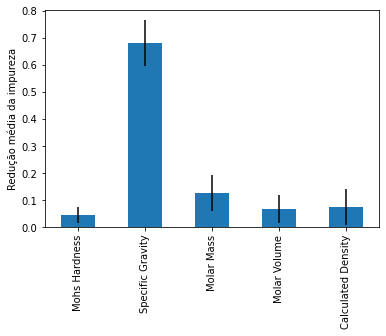

In [24]:
#Análise da importância e desvio padrão dos atributos
importancia = modelo_rf.feature_importances_
desvio_padrao = np.std(
    [arvore.feature_importances_ for arvore in modelo_rf.estimators_], axis=0
)

serie_importancia = pd.Series(importancia, index=atributos)

fig, axe = plt.subplots()
serie_importancia.plot.bar(yerr=desvio_padrao, ax=axe)
axe.set_ylabel("Redução média da impureza")
plt.show()

"Specific Gravity" para o segundo modelo também tem maior importância.

In [25]:
N_REPETICOES = 10


def R2_1param(modelo, x, y):
    """Computa o coef. de determinação quando hip. alt. não tem coef. linear."""
    y_pred = modelo.predict(x).ravel()
    y_true = (np.array(y)).ravel()
    return 1 - sum((y_true - y_pred) ** 2) / sum(y_true**2)


X_local = X_treino
y_local = y_treino

R2 = R2_1param(modelo_rf, X_local, y_local)
print(f"O R^2 da previsão é de {R2}")

# Aqui que calculamos a importância das features
r = permutation_importance(
    modelo_rf,
    X_local,
    y_local,
    n_repeats=N_REPETICOES,
    random_state=seed_rf,
    scoring=R2_1param,
)

print()

# Aqui nós exibimos os resultados obtidos
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{atributos[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

O R^2 da previsão é de 0.9968446243980571

Specific Gravity0.026 +/- 0.001
Molar Mass0.003 +/- 0.000
Calculated Density0.002 +/- 0.000
Molar Volume0.001 +/- 0.000
Mohs Hardness0.001 +/- 0.000


In [26]:
X_local = X_teste
y_local = y_teste

R2 = R2_1param(modelo_rf, X_local, y_local)
print(f"O R^2 da previsão é de {R2}")

# Aqui que calculamos a importância das features
r = permutation_importance(
    modelo_rf,
    X_local,
    y_local,
    n_repeats=N_REPETICOES,
    random_state=seed_rf,
    scoring=R2_1param,
)

print()

# Aqui nós exibimos os resultados obtidos
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{atributos[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

O R^2 da previsão é de 0.9963998166943985

Specific Gravity0.015 +/- 0.001
Molar Volume0.001 +/- 0.000
Mohs Hardness0.001 +/- 0.000
